1.load data and import necessary packages

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from math import log, sqrt, exp
from scipy.optimize import brentq
from scipy.optimize import least_squares

In [21]:
df_discount=pd.read_csv('discount.csv')

In [22]:
google_put=pd.read_csv('goog_put.csv')

In [23]:
google_call=pd.read_csv('goog_call.csv')

2.calculate the duration and middle price of options and forward price of stocks

In [24]:
time_delta=(datetime(2015,1,17)-datetime(2013,8,30)).days

In [25]:
discount_rate=((time_delta-df_discount.Day[11])*df_discount.iloc[:,1][12]
                 +(df_discount.Day[12]-time_delta)*df_discount.iloc[:,1][11])/(df_discount.Day[12]-df_discount.Day[11])

In [26]:
discount_rate/=100

In [27]:
T=time_delta/365

In [28]:
google_call['mid_price']=google_call.apply(lambda x: x[['best_bid','best_offer']].mean(),axis=1)

In [29]:
google_put['mid_price']=google_put.apply(lambda x: x[['best_bid','best_offer']].mean(),axis=1)

In [30]:
stock_price=846.9

In [31]:
F0=stock_price*np.exp(discount_rate*T)

3.calculate market implied volatility

In [32]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [33]:
def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [34]:
out_of_money_put=google_put[google_put['strike']<=F0]

In [35]:
out_of_money_put['implied_vol']=out_of_money_put.apply(lambda x :impliedPutVolatility(stock_price,x['strike'],discount_rate,x['mid_price'],T),axis=1)

<ipython-input-35-b7c7bd9f1d5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_put['implied_vol']=out_of_money_put.apply(lambda x :impliedPutVolatility(stock_price,x['strike'],discount_rate,x['mid_price'],T),axis=1)


In [36]:
out_of_money_call=google_call[google_call['strike']>F0]

In [37]:
out_of_money_call['implied_vol']=out_of_money_call.apply(lambda x : impliedCallVolatility(stock_price,x['strike'],discount_rate,x['mid_price'],T),axis=1)

<ipython-input-37-43aaa49b83d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_call['implied_vol']=out_of_money_call.apply(lambda x : impliedCallVolatility(stock_price,x['strike'],discount_rate,x['mid_price'],T),axis=1)


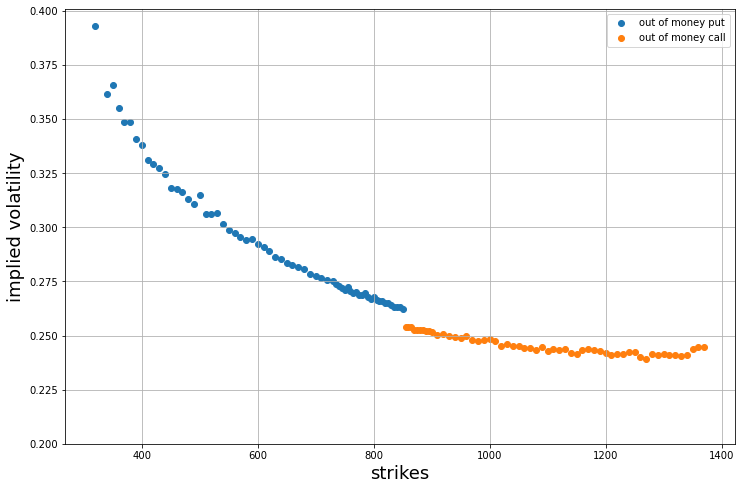

In [38]:
plt.figure(figsize=(12,8))
plt.scatter(out_of_money_put['strike'],out_of_money_put['implied_vol'],label='out of money put')
plt.scatter(out_of_money_call['strike'],out_of_money_call['implied_vol'],label='out of money call')
plt.ylim(0.2)
plt.ylabel('implied volatility',fontdict={'size':18})
plt.xlabel('strikes',fontdict={'size':18})
plt.legend()
plt.grid()
plt.savefig('market')

In [39]:
df=pd.concat((out_of_money_put,out_of_money_call))
df

,date,expiry,strike,best_bid,best_offer,mid_price,implied_vol
0,20130830,20150117,320,0.90,2.00,1.450,0.393102
1,20130830,20150117,340,0.15,2.30,1.225,0.361520
2,20130830,20150117,350,0.80,2.45,1.625,0.365782
3,20130830,20150117,360,0.60,2.65,1.625,0.355104
4,20130830,20150117,370,0.65,2.85,1.750,0.348660
...,...,...,...,...,...,...,...
117,20130830,20150117,1330,5.70,9.00,7.350,0.240758
118,20130830,20150117,1340,5.30,8.60,6.950,0.240881
119,20130830,20150117,1350,5.70,8.20,6.950,0.243821
120,20130830,20150117,1360,5.50,7.80,6.650,0.244487


4.calibrate SABR model to fit the market implied volatility

In [40]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [41]:
beta = 0.8

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'],
                                              df['implied_vol'],
                                              F0,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.991, beta = 0.8, rho = -0.285, nu = 0.352


In [42]:
df['SABR_vol']=df.apply(lambda x : SABR(F0,x['strike'],T,alpha,beta,rho,nu),axis=1)

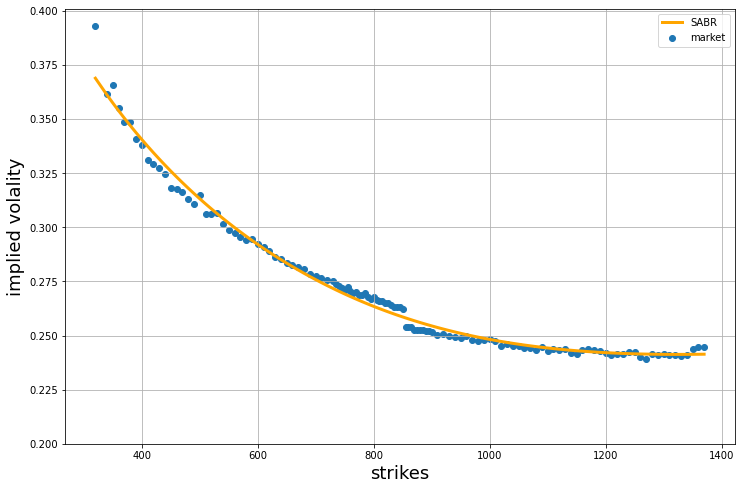

In [43]:
plt.figure(figsize=(12,8))
plt.scatter(df['strike'],df['implied_vol'],label='market')
plt.plot(df['strike'],df["SABR_vol"],label='SABR',color='orange',linewidth=3)
plt.ylim(0.2)
plt.ylabel('implied volality',fontdict={'size':18})
plt.xlabel('strikes',fontdict={'size':18})
plt.legend()
plt.grid()
plt.savefig('sabr')

In [44]:
for i in np.arange(-0.4,0.7,0.2):
    df['SABR_vol_rho=%.2f'% i]=df.apply(lambda x : SABR(F0,x['strike'],T,alpha,beta,i,nu),axis=1)

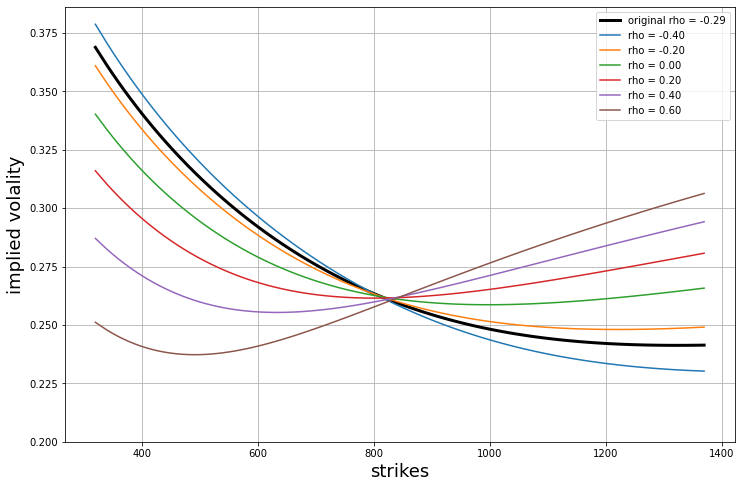

In [45]:
plt.figure(figsize=(12,8))
plt.plot(df['strike'],df['SABR_vol'],color='black',linewidth=3,label='original rho = %.2f'% rho)
for i in np.arange(-0.4,0.7,0.2):
    plt.plot(df['strike'], df['SABR_vol_rho=%.2f'% i],label='rho = %.2f'%i)
plt.ylim(0.2)
plt.ylabel('implied volality',fontdict={'size':18})
plt.xlabel('strikes',fontdict={'size':18})
plt.legend()
plt.grid()
plt.savefig('rho')

In [46]:
for i in np.arange(0.2,0.9,0.2):
    df['SABR_vol_nu=%.2f'% i]=df.apply(lambda x : SABR(F0,x['strike'],T,alpha,beta,rho,i),axis=1)

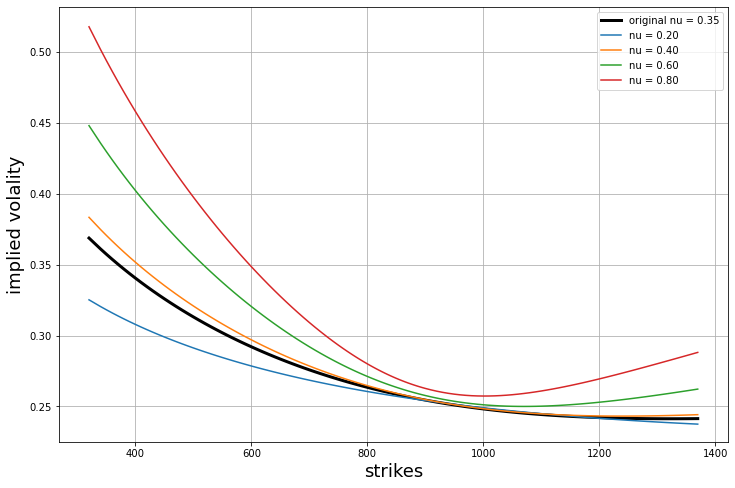

In [54]:
plt.figure(figsize=(12,8))
plt.plot(df['strike'],df["SABR_vol"],label='original nu = %.2f'% nu,color='black',linewidth=3,)
for i in np.arange(0.2,0.9,0.2):
    plt.plot(df['strike'], df['SABR_vol_nu=%.2f'% i],label='nu = %.2f'%i)
plt.ylim(0.225)
plt.ylabel('implied volality',fontdict={'size':18})
plt.xlabel('strikes',fontdict={'size':18})
plt.legend()
plt.grid()
plt.savefig('nu')

In [55]:
out_of_money_put['strike'].iloc[-1]

850

In [56]:
atm_call_vol=impliedCallVolatility(stock_price,out_of_money_call['strike'].iloc[0],discount_rate,out_of_money_call['mid_price'].iloc[0],T)

In [57]:
atm_put_vol=impliedPutVolatility(stock_price,out_of_money_put['strike'].iloc[-1],discount_rate,out_of_money_put['mid_price'].iloc[-1],T)

In [58]:
atm_vol=np.round((atm_put_vol+atm_call_vol)/2,2)

In [59]:
atm_vol

0.26

5.calculate the DisplaceDiffusion model to fit the market implied volatility

In [104]:
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    D = np.exp(-r*T)
    F_ = F/beta
    K_ = K + F*(1-beta)/beta
    sigma_ = sigma*beta
    d1 = (np.log(F_/K_) + sigma_**2*T/2) / (sigma_*np.sqrt(T))
    d2 = d1 - sigma_*np.sqrt(T)
    return D * (F_*norm.cdf(d1) - K_*norm.cdf(d2))


def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    D = np.exp(-r*T)
    F_ = F/beta
    K_ = K + F*(1-beta)/beta
    sigma_ = sigma*beta
    d1 = (np.log(F_/K_) + sigma_**2*T/2) / (sigma_*np.sqrt(T))
    d2 = d1 - sigma_*np.sqrt(T)
    return D * (K_*norm.cdf(-d2) - F_*norm.cdf(-d1))


In [105]:
def DDcalibration(calls,puts,x,S,r,T):
    call_error=0
    for i, vol in enumerate(calls.implied_vol):
        call_error+=(vol-impliedCallVolatility(S,
                                            calls['strike'].iloc[i],
                                            r,
                                            DisplacedDiffusionCall(S,calls['strike'].iloc[i],r,atm_vol,T,x),
                                            T))**2            
    put_error=0
    for i, vol in enumerate(puts.implied_vol):
        put_error+=(vol-impliedPutVolatility(S,
                                            puts['strike'].iloc[i],
                                            r,
                                            DisplacedDiffusionPut(S,puts['strike'].iloc[i],r,atm_vol,T,x),
                                            T))**2
    error=call_error+put_error
    return error   

In [106]:
initialGuess = 0.3
res = least_squares(lambda x: DDcalibration(out_of_money_call,
                                            out_of_money_put,
                                            x,
                                            stock_price,
                                            discount_rate,
                                           T),
                    initialGuess)

In [159]:
beta=res.x[0]
sigma=atm_vol

In [160]:
out_of_money_put['DD_price']=out_of_money_put.apply(lambda x : DisplacedDiffusionPut(stock_price,x['strike'],discount_rate,sigma,T,beta),axis=1)

<ipython-input-160-b8fa1ec9647b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_put['DD_price']=out_of_money_put.apply(lambda x : DisplacedDiffusionPut(stock_price,x['strike'],discount_rate,sigma,T,beta),axis=1)


In [161]:
out_of_money_put['DD_vol']=out_of_money_put.apply(lambda x : impliedPutVolatility(stock_price,x['strike'],discount_rate,x['DD_price'],T),axis=1)

<ipython-input-161-0c82581e6a93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_put['DD_vol']=out_of_money_put.apply(lambda x : impliedPutVolatility(stock_price,x['strike'],discount_rate,x['DD_price'],T),axis=1)


In [162]:
out_of_money_call['DD_price']=out_of_money_call.apply(lambda x : DisplacedDiffusionCall(stock_price,x['strike'],discount_rate,sigma,T,beta),axis=1)

<ipython-input-162-fe64694ef564>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_call['DD_price']=out_of_money_call.apply(lambda x : DisplacedDiffusionCall(stock_price,x['strike'],discount_rate,sigma,T,beta),axis=1)


In [163]:
out_of_money_call['DD_vol']=out_of_money_call.apply(lambda x : impliedCallVolatility(stock_price,x['strike'],discount_rate,x['DD_price'],T),axis=1)

<ipython-input-163-020a1b06ebb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_call['DD_vol']=out_of_money_call.apply(lambda x : impliedCallVolatility(stock_price,x['strike'],discount_rate,x['DD_price'],T),axis=1)


In [164]:
df1=pd.concat((out_of_money_put,out_of_money_call))

In [165]:
for i in np.arange(0.1,0.9,0.2):
    out_of_money_call["DD_price_beta_%.2f"%i]=out_of_money_call.apply(lambda x : DisplacedDiffusionCall(stock_price,x['strike'],discount_rate,sigma,T,i),axis=1)
    out_of_money_call['DD_vol_beta_%.2f'%i]=out_of_money_call.apply(lambda x : impliedCallVolatility(stock_price,x['strike'],discount_rate,x['DD_price_beta_%.2f'%i],T),axis=1)

<ipython-input-165-3f2f9bd26092>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_call["DD_price_beta_%.2f"%i]=out_of_money_call.apply(lambda x : DisplacedDiffusionCall(stock_price,x['strike'],discount_rate,sigma,T,i),axis=1)
<ipython-input-165-3f2f9bd26092>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_call['DD_vol_beta_%.2f'%i]=out_of_money_call.apply(lambda x : impliedCallVolatility(stock_price,x['strike'],discount_rate,x['DD_price_beta_%.2f'%i],T),axis=1)


In [166]:
for i in np.arange(0.1,0.9,0.2):
    out_of_money_put["DD_price_beta_%.2f"%i]=out_of_money_put.apply(lambda x : DisplacedDiffusionPut(stock_price,x['strike'],discount_rate,sigma,T,i),axis=1)
    out_of_money_put['DD_vol_beta_%.2f'%i]=out_of_money_put.apply(lambda x : impliedPutVolatility(stock_price,x['strike'],discount_rate,x['DD_price_beta_%.2f'%i],T),axis=1)

<ipython-input-166-41cc6064bbd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_put["DD_price_beta_%.2f"%i]=out_of_money_put.apply(lambda x : DisplacedDiffusionPut(stock_price,x['strike'],discount_rate,sigma,T,i),axis=1)
<ipython-input-166-41cc6064bbd9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_money_put['DD_vol_beta_%.2f'%i]=out_of_money_put.apply(lambda x : impliedPutVolatility(stock_price,x['strike'],discount_rate,x['DD_price_beta_%.2f'%i],T),axis=1)


In [167]:
df1=pd.concat((out_of_money_put,out_of_money_call))

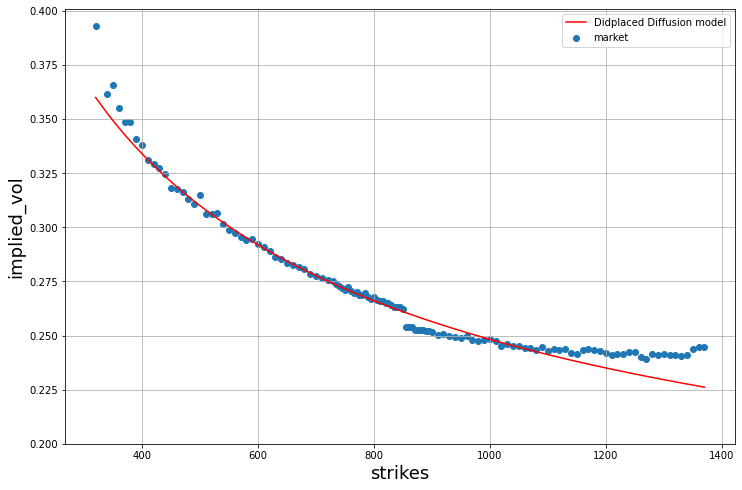

In [168]:
plt.figure(figsize=(12,8))
plt.scatter(df['strike'],df['implied_vol'],label='market')
plt.ylim(0.2)
plt.plot(df1['strike'],df1['DD_vol'],color='red',label='Didplaced Diffusion model')
plt.ylabel('implied_vol',fontdict={'size':18})
plt.xlabel('strikes',fontdict={'size':18})
plt.legend()
plt.grid()
plt.savefig('DD-model')

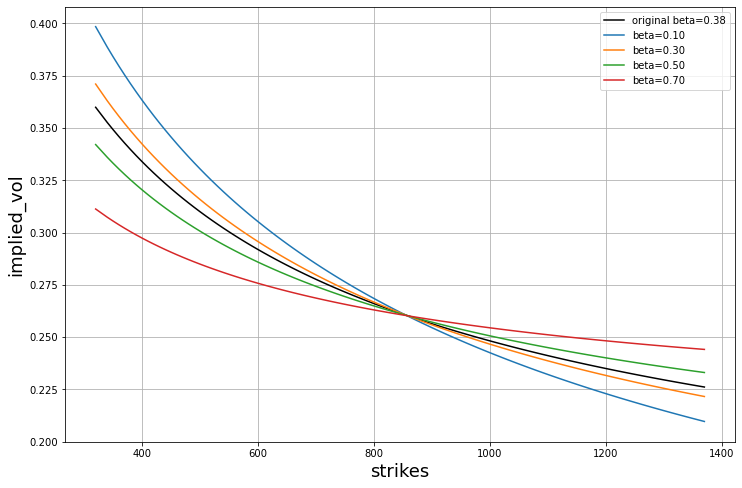

In [49]:
plt.figure(figsize=(12,8))
plt.plot(df1['strike'],df1['DD_vol'],color='black',label='original beta=%.2f'%beta)
for i in np.arange(0.1,0.9,0.2):
    plt.plot(df1['strike'],df1['DD_vol_beta_%.2f'%i],label='beta=%.2f'%i)
plt.ylim(0.2)
plt.ylabel('implied_vol',fontdict={'size':18})
plt.xlabel('strikes',fontdict={'size':18})
plt.legend()
plt.grid()
plt.savefig('beta')